# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.093010,True,7.534945
1,-0.146202,True,2.818488
2,1.342172,True,8.356502
3,0.696062,True,6.269747
4,-0.133053,True,3.491102
...,...,...,...
995,1.337139,True,7.487182
996,1.671579,True,9.103208
997,1.267878,True,6.556997
998,0.847149,True,6.136397


<AxesSubplot:xlabel='v0'>

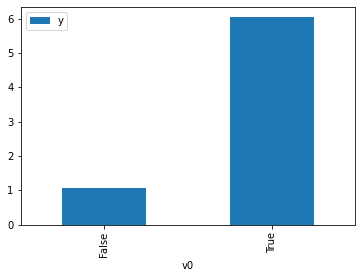

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

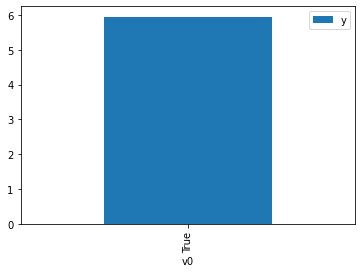

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.955731,False,1.684827,0.178232,5.610674
1,1.565555,False,2.584063,0.077903,12.836519
2,1.565555,False,2.584063,0.077903,12.836519
3,1.550398,False,2.404524,0.079603,12.562383
4,0.382451,False,-1.510288,0.344781,2.900388
...,...,...,...,...,...
995,-0.084194,False,1.265416,0.519838,1.923675
996,-0.562961,False,0.865337,0.694150,1.440612
997,-1.421403,False,-1.747358,0.895368,1.116860
998,0.786344,False,1.315614,0.219858,4.548391


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.442513,True,6.609369,0.675883,1.479545
1,0.652285,True,6.271907,0.742544,1.346721
2,2.158333,True,8.796857,0.967316,1.033788
3,1.240597,True,5.580195,0.877481,1.139626
4,0.652577,True,6.155409,0.742630,1.346565
...,...,...,...,...,...
995,1.351818,True,6.281182,0.894801,1.117567
996,0.904632,True,8.308529,0.809902,1.234717
997,1.351818,True,6.281182,0.894801,1.117567
998,-1.576993,True,2.088792,0.084144,11.884400


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                          1.678e+04
Date:                Wed, 27 Jul 2022   Prob (F-statistic):                        0.00
Time:                        16:22:48   Log-Likelihood:                         -1401.3
No. Observations:                1000   AIC:                                      2807.
Df Residuals:                     998   BIC:                                      2816.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4758      0.036     40.551      0.000       1.404       1.547
x2             5.0722      0.054     94.004      0.000       4.966       5.178
==============================================================================
Omnibus:                        0.509   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.775   Jarque-Bera (JB):                0.394
Skew:                           0.027   Prob(JB):                        0.821
Kurtosis:                       3.080   Cond. No.                         2.76
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""